In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb

In [3]:
!wandb login b032cc059132c9aac4f1b317f6f9ad007ef9e4d4

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Shivam Maurya/.netrc


In [4]:
wandb.init(project="CS6910_Assignment1", name="Question:1")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs22m083. Use `wandb login --relogin` to force relogin


## Question 1 

In [5]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import OneHotEncoder

In [6]:
from matplotlib import pyplot as plt


In [7]:
from tensorflow.keras.datasets.fashion_mnist import load_data

In [8]:
from keras.datasets import fashion_mnist
import warnings
warnings.filterwarnings("ignore")

In [9]:
#Load the fashion MNIST data 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [10]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

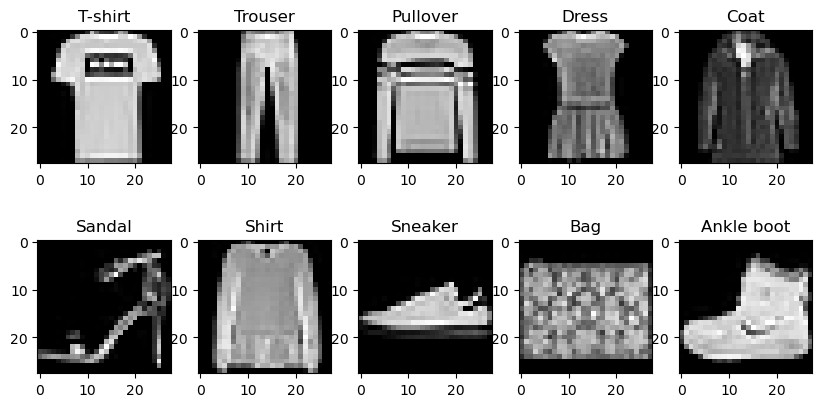

In [12]:
# Plot one sample image for each class
fig, ax = plt.subplots(2, 5, figsize=(10, 5)) #  returns a tuple containing a figure and axes object(s)
ax = ax.ravel()

for i in range(len(class_names)):
    ax[i].set_title(class_names[i])
    # Find the index of the first image with the current label
    idx = np.argmax(y_train == i) # Returns the indices of the maximum values along an axis.
    # Plotting the image
    ax[i].imshow(x_train[idx], cmap= 'gray') # display data as an image 
    wandb.log({"Question1": [wandb.Image(x_train[idx], caption= class_names[i])]})
plt.show()

In [13]:
wandb.finish()

## Question 2


In [14]:
class FFSN_MultiClass:
    def __init__(self, hidden_sizes=[3]):
        self.A = {}
        self.H = {}
        self.n_inputs = 0
        self.n_outputs= 0
        self.W = {}
        self.B = {}
        self.sizes = []
        self.hidden_size = hidden_sizes
        self.n_hidden = len(hidden_sizes)
        
    # Function to initialize the weights between the layers of the network. Weights are initialized randomly.             
    def weights_init(self):
        
        np.random.seed(120)
        np.random.RandomState(120)
        self.sizes = [self.n_inputs] + self.hidden_size + [self.n_outputs]
        for i in range(self.n_hidden + 1):
            size = self.sizes[i+1]
            self.B[i+1] = np.zeros((1, size))# Zero initialization of Biases as matrix of size of 1 * next layer.
            self.W[i+1] = np.random.randn(self.sizes[i], size) # Random initialization of weights per layer.
            


    def forward_pass(self, x, act_fun):
        
        self.H[0] = x.reshape(1, -1)
        
        for i in range(self.n_hidden):
            bias = self.B[i+1]
            weight = self.W[i+1]
            self.A[i+1] = np.matmul(self.H[i], weight) + bias
            self.H[i+1] = self.activation_fun( act_fun,  self.A[i+1] )
            
        self.A[self.n_hidden+1] = np.matmul(self.H[self.n_hidden], self.W[self.n_hidden+1]) + self.B[self.n_hidden+1]
        self.H[self.n_hidden+1] = self.softmax(self.A[self.n_hidden+1])
        return self.H[self.n_hidden+1]
    
    def predict(self, X, act_fun):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x, act_fun)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def activation_fun(self, fun, X):
        
        if fun == "tanh":
            return self.tanh(X)
        elif fun == "relu":
            return self.relu(X)
        else:
            return self.sigmoid(X);
        
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        y = (x > 0)
        return X * y
        
    
    #Sigmoid Function
    def sigmoid(self, x):
        
        return (1./(1.0 + np.exp(-x)))


    def fit(self, act_fun, X, Y):
        ny = Y.shape[1]
        self.n_inputs = X.shape[1] * X.shape[1]
        self.n_outputs = ny
        self.weights_init()
        
        
        return self.predict(X, act_fun)

In [15]:
enc = OneHotEncoder()
x_train = x_train/255.0
x_test = x_test/255.0
y_OH_test = enc.fit_transform(np.expand_dims(y_test, 1)).toarray()
y_OH_train = enc.fit_transform(np.expand_dims(y_train, 1)).toarray()
print(y_OH_train.shape, y_OH_test.shape)
print(x_train.shape)

(60000, 10) (10000, 10)
(60000, 28, 28)


In [16]:
layr = [150, 260, 380]
obj = FFSN_MultiClass(layr)
activation_name = "sigmoid"
clas_pred = obj.fit(activation_name, x_train, y_OH_train)

In [17]:
np.set_printoptions(suppress=True)

In [18]:
 print(clas_pred[50])

[0.00024276 0.0001071  0.         0.         0.00000016 0.98679121
 0.00390697 0.00005168 0.00000237 0.00889774]


In [19]:
print(y_OH_train[50])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Question 3

In [20]:
class FFNN():
 
    def __init__(self,opt, hidden_sizes, loss_fun, activation_fun, output_act, b_s= 1024, epochs = 10, initialization = "Random", log=0, train_losses = None, train_accuracy = None, test_losses = None, test_accuracy = None):
        
        self.train_accuracy_list = train_accuracy
        self.batch_size = b_s
        self.layer_sizes = []
        self.output_activation = output_act
        self.dw = {}
        self.output_layer_size=1
        self.input_layer_size=0
        self.A = {}
        self.hidden_layer_sizes = hidden_sizes
        self.dH = {}
        self.loss_function = loss_fun
        self.H = {}
        self.train_losses_list = train_losses
        self.optimizer = opt
        self.dA = {}
        self.activation_function = activation_fun
        self.weights = {}
        self.db = {}
        self.biases = {}
        #Layer sizes array will be initialzed after input and output layer size is obtained
        self.val_accuracy_list = test_accuracy
        self.val_losses_list = test_losses
        self.wan_log = log
        self.epochs = epochs
        self.initialization = initialization


    def initialize_weights(self):
      
        #Function to initialize the weights between the layers of the network. Weights are initialized randomly.
        self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
        np.random.seed(137)
        np.random.RandomState(137)
        ln = len(self.hidden_layer_sizes)
        self.optimizer.initialize(self.layer_sizes)
        weight_counts =ln  +1
        for i in range(weight_counts):
            
            s_size = (self.layer_sizes[i], self.layer_sizes[i+1])
            lsize_i = self.layer_sizes[i]
            lsize_i1 = self.layer_sizes[i+1]
        
            if self.initialization == "Xavier":
               
                self.weights[i+1] = np.random.normal(0.0, np.sqrt(2 / float(lsize_i + lsize_i1)) , size = s_size)

            elif self.initialization == "Random":
               
                self.weights[i+1] = np.random.randn(lsize_i, lsize_i1)
            self.biases[i+1] = np.zeros((1, lsize_i1))


    def forward_propogation(self, X):
        
        ln = len(self.hidden_layer_sizes)
        
        self.H = {}
        #Initialize the output from input layer as H[0] into a single row(row vector)
        self.H[0] = X.reshape(1,-1)
        self.A = {}
        #Compute a(x) = W_x*h(x-1) and h(a(x)) = activation(a(x)) for hidden layer
        for i in range(ln):
            weight = self.weights[i+1]
            bias = self.biases[i+1]
            self.A[i+1] = np.matmul(self.H[i], weight) + bias
            self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

        ln = ln +1
        weight = self.weights[ln]
        bias = self.biases[ln]
        self.A[ln] = np.matmul(self.H[ln-1], weight) + bias
        #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
        self.H[ln] = self.output_activation.compute_activation(self.A[ln]) 
        return  self.H[ln]

    def backward_propogation(self, X, Y,  dw_i, db_i):
        
        ln = len(self.hidden_layer_sizes)
        #Compute the gradient of loss wrt the activation of output layer
        self.dA[ln +1] = self.loss_function.last_output_derivative(self.H[ln +1], Y, self.output_activation.compute_derivative(self.A[ln +1]))

        #Compute the partial derivatives for the weights and biases of the layers
        # change in weight : (assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
        # change in biase : (assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
        for i in range(ln, -1, -1):
            weight = self.weights[i+1].T
            db_i[i+1] = self.dA[i+1]
            dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
            
            if i!=0:
                self.dH[i] = np.matmul(self.dA[i+1],weight)  
                act_grad = self.activation_function.compute_derivative(self.A[i])
                self.dA[i] = np.multiply(act_grad, self.dH[i])    
               
        return dw_i, db_i


    def fit(self, X, Y, X_val, Y_val, console = 1):
        
        #Function to fit the data (X,Y) on the model. This performs forward + backward pass for epoch number of times. Gradient is updated after each batch is processed.
        self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
        self.console_log = console
        self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
        hidden_ls = self.hidden_layer_sizes
        self.initialize_weights()
        ln = len(self.hidden_layer_sizes)+1
        for e in range(self.epochs):
            count = -1
            for i in range(ln):
                layer_size = self.layer_sizes[i+1]
                self.db[i+1] = np.zeros((1, layer_size))
                self.dw[i+1] = np.zeros((self.layer_sizes[i], layer_size))
                
            y_preds = []

            for x, y in zip(X, Y):
                count += 1
                db_i = {}
                dw_i = {}

                if count==self.batch_size:
                    #Done wih current batch
        
                    if self.optimizer.optimizer_name()=="nag":
                        b_lookahead = {}
                        w_lookahead = {}
                        
                        for i in range(ln):
                            b_upd = self.optimizer.gamma*self.optimizer.update_history_b[i+1]
                            w_upd = self.optimizer.gamma*self.optimizer.update_history_w[i+1]
                            b_lookahead[i+1] = self.biases[i+1] - b_upd
                            w_lookahead[i+1] = self.weights[i+1] - w_upd
                            
                        
                        weights_old = self.weights
                        self.weights = w_lookahead
                        self.forward_propogation(x)
                        dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
                        self.biases = b_lookahead
                        biases_old = self.biases
                        self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, hidden_ls)

                    else: 
                        self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, hidden_ls)
                    
                    for i in range(ln):
                        lsize1 = self.layer_sizes[i+1]
                        lsize = self.layer_sizes[i]
                        self.db[i+1] = np.zeros((1, lsize1))
                        self.dw[i+1] = np.zeros((lsize, lsize1))

                    count = 0
                #Forward Propogation
                self.forward_propogation(x)

                #Predictions
                y_preds.append(self.H[ln])

                #Backward Propogation using Loss funtion
                self.backward_propogation(x,y, dw_i, db_i) 

                for i in range(ln):
                    b_i = db_i[i+1]
                    w_i = dw_i[i+1]
                    self.db[i+1] = self.db[i+1] + b_i
                    self.dw[i+1] = self.dw[i+1] + w_i
                    
           
            #Update weights based on loss(GD hence once every epoch update)
            if self.optimizer.optimizer_name()=="nag":
                b_lookahead = {}
                w_lookahead = {}
                
                for i in range(ln):
                    bias = self.biases[i+1]
                    weight = self.weights[i+1]
                    b_upd = self.optimizer.gamma*self.optimizer.update_history_b[i+1]
                    w_upd = self.optimizer.gamma*self.optimizer.update_history_w[i+1]
                    b_lookahead[i+1] = bias - b_upd
                    w_lookahead[i+1] = weight - w_upd     
                
                biases_old, weights_old= self.biases, self.weights
                self.biases, self.weights = b_lookahead , w_lookahead
                
                self.forward_propogation(x)
                dw_lookahead, db_lookahead = self.backward_propogation(x, y, dw_i, db_i) 
                self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, hidden_ls)

            else:  
                self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, hidden_ls)
            
            y_preds = np.array(y_preds).squeeze()
            y_preds_validation = self.predict(X_val)
            
            validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation, self.batch_size)
            if self.val_losses_list != None:
                self.val_losses_list.append(validation_loss) 
            
            training_loss = self.loss_function.compute_loss(Y, y_preds, self.batch_size)
            if self.train_losses_list != None:
                self.train_losses_list.append(training_loss)
                
            validation_accuracy = accuracy_score(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
            if self.val_accuracy_list != None:
                self.val_accuracy_list.append(validation_accuracy)
                
            training_accuracy = accuracy_score(np.argmax(Y,1), np.argmax(y_preds,1))
            if self.train_accuracy_list != None:
                self.train_accuracy_list.append(training_accuracy)
           
              
            if self.console_log == 1: #For Printing Log results on Console 
                print("Training Loss: ",round(training_loss,3),"Val_loss:", round(validation_loss, 3), " Training Accuracy: ",round(training_accuracy,3), "Val_accuracy:", round(validation_accuracy,3), " <-:Epoch:",e+1,)
            
            
            elif self.wan_log==1:#For Log metrics on wandb
                
                wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})

    
        return training_loss, validation_loss, training_accuracy, validation_accuracy

    def predict(self, X):
        y_pred = []
        for x in X:
            pred = self.forward_propogation(x)
            y_pred.append(pred)

        y_pred = np.array(y_pred).squeeze()
        return y_pred

## Optimization Function

In [21]:
class Optimizer():
    
    def __init__(self, optimizer,  learning_rate = 0.001,  gamma = 0.001, beta1 = 0.9, beta2 = 0.999, weight_decay = 0.0, epsilon = 1e-8):
        
        self.update_history_b = {}
        self.m_b = {}
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.db_look_ahead = {}
        self.b_look_ahead = {}
        self.weight_decay = weight_decay
        self.v_b = {}
        self.dw_look_ahead ={}
        self.gamma = gamma
        self.w_look_ahead = {}
        self.update_history_w = {}
        self.lr =0
        self.epsilon = epsilon
        self.m_w = {}
        self.v_w ={}
        if( self.optimizer == "sgd"):
            self.learning_rate = learning_rate
            self.weight_decay = weight_decay
            
        if( self.optimizer == "momentum" ):
            self.weight_decay = weight_decay
            self.initialized = False
            self.update_history_w = {}
            self.learning_rate = learning_rate
            self.update_history_b = {}
            self.gamma = gamma
        
        if( self.optimizer == "nag"):
            self.initialized = False
            self.update_history_b = {}
            self.update_history_w = {}
            self.learning_rate = learning_rate
            self.b_look_ahead={}
            self.w_look_ahead={}
            self.gamma = gamma
            self.db_look_ahead={}
            self.dw_look_ahead={}

        if( self.optimizer == "rmsprop"):
            self.initialized = False
            self.weight_decay = weight_decay
            self.v_b = {}
            self.v_w = {}
            self.epsilon = epsilon
            self.gamma = gamma
            self.learning_rate = learning_rate
            
            

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            self.initialized = False
            self.epsilon = epsilon
            self.v_b = {}
            self.v_w = {}
            self.beta1 = beta1
            self.beta2 = beta2
            self.m_b = {}
            self.m_w = {}
            self.iterations = 1
            self.learning_rate = learning_rate
            self.weight_decay = weight_decay
        

    def set_learning_rate(self, learning_rate):

        if(self.optimizer == "sgd"):
            self.learning_rate = learning_rate

        if( self.optimizer == "momentum" ):
            self.learning_rate = learning_rate
        
        if( self.optimizer == "nag"):
            self.learning_rate = learning_rate

        if( self.optimizer == "rmsprop"):
            self.learning_rate = learning_rate

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            self.learning_rate = learning_rate



    def set_weight_decay(self, weight_dec):
        self.weight_decay = weight_dec
        
    def set_initial_parameters(self, parameters):
        
        if(self.optimizer == "sgd"):
            self.weight_decay = parameters["weight_decay"]
            self.learning_rate = parameters["learning_rate"]

        if( self.optimizer == "momentum" ):
            self.weight_decay = parameters["weight_decay"]
            self.gamma = parameters["gamma"]
            self.learning_rate = parameters["learning_rate"]
            
        
        if( self.optimizer == "nag"):
            self.gamma = parameters["gamma"]
            self.learning_rate = parameters["learning_rate"]

        if( self.optimizer == "rmsprop"):
            
            self.weight_decay = parameters["weight_decay"]
            self.learning_rate = parameters["learning_rate"]
            self.lr = 0.01
            self.epsilon = parameters["epsilon"]
            self.gamma = parameters["gamma"]
            

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            self.weight_decay = parameters["weight_decay"]
            self.lr = 0.01
            self.epsilon = parameters["epsilon"]
            self.beta1, self.beta2  = parameters["beta1"], parameters["beta2"]
            self.learning_rate = parameters["learning_rate"]
            
    def initialize(self, all_layers):
        
        self.b_look_ahead.clear()
        self.update_history_b.clear()
        ln = len(all_layers)
        self.m_b.clear()
        self.dw_look_ahead.clear()
        self.v_b.clear()
        self.w_look_ahead.clear()
        ln = ln -1
        self.update_history_w.clear()
        self.m_w.clear()
        self.db_look_ahead.clear()
        self.v_w.clear()
        
        if(self.optimizer == "sgd"):
            return

        if( self.optimizer == "momentum" ):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.update_history_b[i+1] = np.zeros((1, all_layer))
                self.update_history_w[i+1] = np.zeros((all_layers[i], all_layer))
                
        if( self.optimizer == "nag"):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.update_history_w[i+1] = np.zeros((all_layers[i], all_layer))
                self.dw_look_ahead[i+1] = np.zeros((all_layers[i], all_layer))
                self.w_look_ahead[i+1] = np.zeros((all_layers[i], all_layer))
                self.update_history_b[i+1] = np.zeros((1, all_layer))
                self.db_look_ahead[i+1] = np.zeros((1, all_layer))
                self.b_look_ahead[i+1] = np.zeros((1, all_layer))

        if( self.optimizer == "rmsprop"):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.v_w[i+1] = np.zeros((all_layers[i], all_layer))
                self.v_b[i+1] = np.zeros((1, all_layer))

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.m_b[i+1] = np.zeros((1, all_layer))
                self.v_b[i+1] = np.zeros((1, all_layer))
                self.m_w[i+1] = np.zeros((all_layers[i], all_layer))
                self.v_w[i+1] = np.zeros((all_layers[i], all_layer))
                
    def optimizer_name(self):

        if(self.optimizer == "sgd"):
            return "sgd"

        if( self.optimizer == "momentum" ):
            return "momentum"
        
        if( self.optimizer == "nag"):
            return "nag"

        if( self.optimizer == "rmsprop"):
            return "rmsprop"

        if( self.optimizer == "adam"):
            return "adam"
        if( self.optimizer == "nadam"):
            return "nadam"

    def update_parameters(self, weights, biases, dw, db, layers):
        nlayer = len(layers)+1
        if(self.optimizer == "sgd"):
            for i in range(nlayer):
                decay_wt = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + decay_wt
                grad_b = self.learning_rate * db[i+1]
                grad_w = self.learning_rate * dw[i+1]
                biases[i+1] = biases[i+1] - grad_b # b_t = b_{t-1} - eta*(dL/db)
                weights[i+1] = weights[i+1] - grad_w # w_t = w_{t-1} - eta*(dL/dw)
            
            return weights, biases

        if( self.optimizer == "momentum" ):
            """
            Function to perform the weight update step based on optimizer algorithm
            """

            for i in range(nlayer):
                
                wt_decay = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + wt_decay
                upd_bias = self.learning_rate*db[i+1]
                upd_weight = self.learning_rate*dw[i+1]
                self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + upd_bias 
                self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + upd_weight
                biases[i+1] = biases[i+1] - self.update_history_b[i+1]
                weights[i+1] = weights[i+1] - self.update_history_w[i+1]
            
            return weights, biases
        
        if( self.optimizer == "nag"):
            """
            Function to perform the weight update step based on optimizer algorithm
            """
            for i in range(nlayer):
                
                grad_db = self.learning_rate*db[i+1]
                grad_dw = self.learning_rate*dw[i+1]
                self.update_history_b[i+1] = self.gamma*self.update_history_b[i+1] 
                self.update_history_b[i+1] += grad_db
                biases[i+1] = biases[i+1] - self.update_history_b[i+1]
                self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] 
                self.update_history_w[i+1] += grad_dw
                weights[i+1] = weights[i+1] - self.update_history_w[i+1]
                

            return weights, biases

        if( self.optimizer == "rmsprop"):
            for i in range(nlayer):
                eps = self.epsilon
                lr = self.learning_rate
                wt_decay = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + wt_decay
                
                v_weight = self.gamma*self.v_w[i+1] 
                self.v_w[i+1] = v_weight + (1-self.gamma)* ((dw[i+1])**2)
                
                v_bias = self.gamma*self.v_b[i+1]
                self.v_b[i+1] = v_bias + (1-self.gamma)* ((db[i+1])**2)
                
                biase_upd = ((lr)/np.sqrt(self.v_b[i+1] + eps))*db[i+1]
                weight_upd = ((lr)/np.sqrt(self.v_w[i+1] + eps))*dw[i+1]

                biases[i+1] = biases[i+1] - biase_upd
                weights[i+1] = weights[i+1] - weight_upd
            
            return weights, biases

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            #Function to perform the weight update step based on optimizer algorithm
           
            for i in range(nlayer):
                eps = self.epsilon
                lr = self.learning_rate
                upd_wt = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + upd_wt

                m_bias = self.beta1*self.m_b[i+1] 
                self.m_b[i+1] = m_bias + (1-self.beta1)* (db[i+1])
                m_weight = self.beta1*self.m_w[i+1] 
                self.m_w[i+1] = m_weight + (1-self.beta1)* (dw[i+1])
                v_weight = self.beta2*self.v_w[i+1] 
                self.v_w[i+1] = v_weight + (1-self.beta2)* ((dw[i+1])**2)
                v_bias = self.beta2*self.v_b[i+1] 
                self.v_b[i+1] = v_bias + (1-self.beta2)* ((db[i+1])**2)
                
                v_hat_div = (1-(self.beta2**self.iterations))
                m_hat_div = (1-(self.beta1**self.iterations))
                v_b_hat = self.v_b[i+1] / v_hat_div
                m_b_hat = self.m_b[i+1] / m_hat_div
                v_w_hat = self.v_w[i+1] / v_hat_div
                m_w_hat = self.m_w[i+1] / m_hat_div
                nadam_impl = (1-self.beta1)/(1-(self.beta1**self.iterations))
                if(self.optimizer == "nadam"):
                    weight_upd = ((lr)/(np.sqrt(v_w_hat) + eps))*(self.beta1 * m_w_hat + (nadam_impl * dw[i+1]))
                    weights[i+1] = weights[i+1] - weight_upd
                    biases_upd = ((lr)/(np.sqrt(v_b_hat) + eps))*(self.beta1 * m_b_hat + (nadam_impl * db[i+1]))
                    biases[i+1] = biases[i+1] - biases_upd
                elif(self.optimizer == "adam"):
                    weights_upd = ((lr)/(np.sqrt(v_w_hat) + eps))*(m_w_hat)
                    biases_upd = ((lr)/(np.sqrt(v_b_hat) + eps))*(m_b_hat)
                    
                    weights[i+1] = weights[i+1] - weights_upd
                    biases[i+1] = biases[i+1] - biases_upd
                
                nadam_impl = (1-self.beta1)/(1-(self.beta1**self.iterations))
                
            self.iterations = self.iterations + 1
            
            return weights, biases


## Activation Function

In [22]:
class ActivationFunction():
    def __init__(self, fun = "sigmoid"):
        self.act_fun = fun

    def compute_activation(self, X):

        if(self.act_fun == "sigmoid"):
            return 1.0/(1.0+np.exp(-X)) # sigmoid function
        if(self.act_fun == "softmax"):
            exponentials = np.exp(X) # softmax function
            return exponentials / np.sum(exponentials)
        if(self.act_fun == "tanh"):
            return np.tanh(X) # tanh function
        if(self.act_fun == "relu"):
            return X * (X > 0) # relu function
            
    def compute_derivative(self, X):
        if(self.act_fun == "sigmoid"):
            val = self.compute_activation(X)
            return val*(1-val)
        if(self.act_fun == "softmax"):
            softmax = self.compute_activation(X)
            return softmax*(1-softmax)
        if(self.act_fun == "tanh"):
            return 1 - (np.tanh(X) ** 2)
        if(self.act_fun == "relu"): 
            X[X > 0.0] = 1.0
            X[X <= 0.0] = 0.0
            return X

## Loss Function

In [23]:
class LossFunction():
    def __init__(self, fun = "cross_entropy"):
        self.loss_fun = fun
    
    def compute_loss(self, Y_true, Y_pred, batch_size):
        ln = len(Y_true)
        lss = 0
        if(self.loss_fun == "squared_loss"):
            return (1/2) * np.sum((Y_pred-Y_true)**2) / ln
        
        if(self.loss_fun == "cross_entropy"):
            for p in Y_pred[0]:
                if p < 10e-8  or np.isnan(p):
                    p = 10e-8
                    lss += 1
            loss = np.multiply(Y_pred,Y_true)
            loss = loss[loss != 0]
            lss  = loss
            loss = -np.log(loss)
            loss = np.mean(loss)
            return loss

    def name(self):
        if(self.loss_fun == "squared_loss"):
            return "squared_loss" 
        
        if(self.loss_fun == "cross_entropy"):
            return "cross_entropy_loss"

    def compute_derivative(self, Y_pred,Y_true):
        
        if(self.loss_fun == "squared_loss"):
            return (Y_pred)*(Y_pred-Y_true)/len(Y_true)
        
        if(self.loss_fun == "cross_entropy"):
            return -Y_true/(Y_pred)
            

    def last_output_derivative(self, Y_pred,Y_true,activation_derivative):
        ln = len(Y_true)
        lss = 0
        for p in Y_pred[0]:
                if (np.isnan(p) or p < 10e-8):
                    lss += 1
                    p = 10e-8
        if(self.loss_fun == "squared_loss"):
            return (Y_pred - Y_true)*activation_derivative / ln
        
        if(self.loss_fun == "cross_entropy"):
            return -(Y_true - Y_pred)

## Testing Model

In [ ]:
# Parameters Selection for Different Optimization Algorithm
parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5} #sgd
parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0} #momentum
parameters_nag = {"learning_rate":0.001, "gamma":0.009} #nag
parameters_rmsprop = {"learning_rate":0.01, "gamma":0.009, "epsilon":1e-8, "weight_decay":0.5} #rmsprop
parameters_adam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #adam
parameters_nadam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #nadam


# "sgd" : gradient_descent, "momentum" : momentum_gd, "nag": nag , "rmsprop":  RMSProp, "adam": Adam "nadam": Nadam

optimizer = Optimizer("adam")
optimizer.set_initial_parameters(parameters_adam)


#  "cross_entropy" : Cross Entropy Loss Function,  "squared_loss" : Squared Error Loss Function
loss_fun = LossFunction("cross_entropy")

#Select activation-function(hidden layers) pass below respective string to select any Activation Fuction Eg:"tanh" in ActivationFunction
# "sigmoid": SigmoidFunction, "softmax": SoftmaxFunction, "tanh": TanhFunction, "relu":ReLUFunction
act_fun_hidden = ActivationFunction("tanh")

#Select activation - function for output layer
act_fun_output = ActivationFunction("softmax")

#Add layer sizes for the hidden layers
layers = [32, 64, 128]
batch_size = 64
model = FFNN(optimizer, layers, loss_fun, act_fun_hidden, act_fun_output, batch_size, 10, initialization = "Xavier")
train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test)


Training Loss:  0.559 Val_loss: 0.455  Training Accuracy:  0.799 Val_accuracy: 0.835  <-:Epoch: 1
Training Loss:  0.401 Val_loss: 0.416  Training Accuracy:  0.854 Val_accuracy: 0.848  <-:Epoch: 2
Training Loss:  0.366 Val_loss: 0.399  Training Accuracy:  0.866 Val_accuracy: 0.855  <-:Epoch: 3
Training Loss:  0.344 Val_loss: 0.388  Training Accuracy:  0.874 Val_accuracy: 0.858  <-:Epoch: 4


In [ ]:
#Accuracy for test data
y_preds = model.predict(x_test)
accuracy_train = accuracy_score(np.argmax(y_OH_test,1), np.argmax(y_preds,1))
print("Training accuracy", round(accuracy_train, 3))
print("Validation Loss:", round(val_loss,3), "Validation Accuracy:", round(val_accuracy,3))

## Question 4

In [26]:
sweep_config = {
    #RandomSearch over the hyperparameters
    'method': 'random',
    'metric': { 'goal': 'maximize','name': 'accuracy'},
    
    'parameters': {'activation': {'values': ['sigmoid' , 'tanh', 'relu']},
                
                    'batch_size':{'values':[16,32,64]},
                    'optimizer': {'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']},
                    'hidden_layers': {'values': [ [32,64],[32,64,128],[32,64,128,256]]},
                    'epochs': {'values': [5,10]},
                    'weight_decay': {'values': [0.0, 0.0005, 0.5]},
                    'gamma': {'values': [0.03, 0.0006, 0.002]},
                    'learning_rate': {'values': [0.0001, 0.005, 0.0006, 0.01, 0.0003, 0.0005]},
                    'initialization':{'values': ['Xavier', 'Random']}
                  }
               }

In [27]:
def train():

    var1 = wandb.init(project="CS6910_Assignment1", name="Question:4")
    var2 = var1.config

    # var2 is a variable that holds and saves hyperparameters and inputs
    wandb.run.name = 'optimizer:-' + var2.optimizer + ' epochs:-' + str(var2.epochs) + ' activation:-' + var2.activation + ' init:-' + var2.initialization + ' layers:-' + str(len(var2.hidden_layers)) +' decay:-' + str(var2.weight_decay) + ' gamma:-' + str(var2.gamma) + ' learning_rate:-' + str(var2.learning_rate) + ' batch_size:-' + str(var2.batch_size)

    
    loss_fun = LossFunction("cross_entropy")
    epochs = var2.epochs
    weight_decay = var2.weight_decay
    hidden_layers = var2.hidden_layers
    gamma = var2.gamma
    learning_rate = var2.learning_rate

    if var2.activation=="sigmoid":
        activation = ActivationFunction("sigmoid")
    if var2.activation=="tanh":
        activation = ActivationFunction("tanh")
    if var2.activation=="relu":
        activation = ActivationFunction("relu")

    output_activation = ActivationFunction("softmax")


    parameters_sgd = {"learning_rate": learning_rate, "weight_decay":weight_decay}
    parameters_momentum = {"learning_rate": learning_rate, "gamma": gamma, "weight_decay":weight_decay}
    parameters_nag = {"learning_rate": learning_rate, "gamma": gamma}
    parameters_rmsprop = {"learning_rate": learning_rate, "gamma":gamma, "epsilon":1e-8, "weight_decay":weight_decay}
    parameters_adam = {"learning_rate": learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
    parameters_nadam = {"learning_rate": learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}

    if var2.optimizer=="sgd":
        optimizer = Optimizer("sgd")
        optimizer.set_initial_parameters(parameters_sgd)

    if var2.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = Optimizer("momentum")
        optimizer.set_initial_parameters(parameters_momentum)

    if var2.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = Optimizer("nag")
        optimizer.set_initial_parameters(parameters_nag)

    if var2.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = Optimizer("rmsprop")
        optimizer.set_initial_parameters(parameters_rmsprop)

    if var2.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = Optimizer("adam")
        optimizer.set_initial_parameters(parameters_adam)

    if var2.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = Optimizer("nadam")
        optimizer.set_initial_parameters(parameters_nadam)

    if(var2.initialization == "Random"):
        initn = "Random"
    else:
        initn = "Xavier"
    
    batch_size = var2.batch_size

    #Model training 
    #Ensure that log=1 parameter is set for logging onto wandb
    model = FFNN(optimizer, hidden_layers, loss_fun, activation, output_activation, batch_size, epochs, initn, log=1)

    train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test, console= 0)
    print(" Training Loss: ",train_loss, " Validation Loss:",val_loss ," Training Accuracy: ",train_accuracy, " Validation Accuracy:", val_accuracy)

    #Log validation accuracy for this run
    wandb.log({"Accuracy": val_accuracy})

In [28]:
sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment1")

Create sweep with ID: gb9w2qt6
Sweep URL: https://wandb.ai/cs22m083/CS6910_Assignment1/sweeps/gb9w2qt6


In [29]:
wandb.agent(sweep_id, train, count = 60)

wandb: Agent Starting Run: j639os4x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  5.460824419269098  Validation Loss: 5.638637393834711  Training Accuracy:  0.5682  Validation Accuracy: 0.5527


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▄▂▁
Validation_accuracy,▁▆▅▇█
Validation_loss,█▃▃▁▁
Accuracy,0.5527
Epoch,5
Training_accuracy,0.5682
Training_loss,5.46082
Validation_accuracy,0.5527


wandb: Agent Starting Run: djmto2i4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7629437852946944  Validation Loss: 0.7313029785663262  Training Accuracy:  0.7117333333333333  Validation Accuracy: 0.716


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▆▇█
Training_loss,█▅▃▂▁
Validation_accuracy,▁▄▇██
Validation_loss,█▅▃▂▁
Accuracy,0.716
Epoch,5
Training_accuracy,0.71173
Training_loss,0.76294
Validation_accuracy,0.716


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: if9nknsh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0348830002874163  Validation Loss: 1.0403913951850823  Training Accuracy:  0.6530666666666667  Validation Accuracy: 0.6461


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▄▃▂▁
Accuracy,0.6461
Epoch,5
Training_accuracy,0.65307
Training_loss,1.03488
Validation_accuracy,0.6461


wandb: Agent Starting Run: eqe5hm19 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6040174440270617  Validation Loss: 0.6165740893559234  Training Accuracy:  0.8042166666666667  Validation Accuracy: 0.7984


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆███
Training_loss,█▂▁▁▁
Validation_accuracy,▁▇███
Validation_loss,█▂▁▁▁
Accuracy,0.7984
Epoch,5
Training_accuracy,0.80422
Training_loss,0.60402
Validation_accuracy,0.7984


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: reszmbof with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  15.554036408298254  Validation Loss: 10.524231756082578  Training Accuracy:  0.1004  Validation Accuracy: 0.1002


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▅█▄▁▁
Training_loss,▃▁▄██
Validation_accuracy,▇█▁▁▁
Validation_loss,▂▁█▅▃
Accuracy,0.1002
Epoch,5
Training_accuracy,0.1004
Training_loss,15.55404
Validation_accuracy,0.1002


wandb: Agent Starting Run: 9p5j3ek9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3416145907696603  Validation Loss: 0.4034444942656234  Training Accuracy:  0.87365  Validation Accuracy: 0.8555


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▂▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▄▂▁▁
Accuracy,0.8555
Epoch,5
Training_accuracy,0.87365
Training_loss,0.34161
Validation_accuracy,0.8555


wandb: Agent Starting Run: vpz3j935 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.606923995180844  Validation Loss: 0.6300947973921138  Training Accuracy:  0.7817666666666667  Validation Accuracy: 0.7798


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▆▇█
Training_loss,█▃▂▂▁
Validation_accuracy,▁▅▅▇█
Validation_loss,█▄▃▂▁
Accuracy,0.7798
Epoch,5
Training_accuracy,0.78177
Training_loss,0.60692
Validation_accuracy,0.7798


wandb: Agent Starting Run: 50h9cfqk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁█████████
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: z9d93agy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3802187442898779  Validation Loss: 0.4203709719804231  Training Accuracy:  0.86235  Validation Accuracy: 0.8503


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇▇███
Training_loss,█▄▃▂▂▂▂▁▁▁
Validation_accuracy,▁▃▄▅▇▇▇▆▇█
Validation_loss,█▆▅▄▃▂▂▃▂▁
Accuracy,0.8503
Epoch,10
Training_accuracy,0.86235
Training_loss,0.38022
Validation_accuracy,0.8503


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: covrapu0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.9871069401931172  Validation Loss: 0.9883903889525555  Training Accuracy:  0.62745  Validation Accuracy: 0.6265


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▅▆▇▇▇███
Training_loss,█▄▃▂▂▂▁▁▁▁
Validation_accuracy,▁▄▅▆▇▇▇███
Validation_loss,█▅▄▃▂▂▂▁▁▁
Accuracy,0.6265
Epoch,10
Training_accuracy,0.62745
Training_loss,0.98711
Validation_accuracy,0.6265


wandb: Agent Starting Run: zr8wnnm1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.3511263333655512  Validation Loss: 1.0968944434055754  Training Accuracy:  0.6762833333333333  Validation Accuracy: 0.6798


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▇██
Training_loss,█▃▁▁▁
Validation_accuracy,▁▂██▇
Validation_loss,█▇▁▁▂
Accuracy,0.6798
Epoch,5
Training_accuracy,0.67628
Training_loss,1.35113
Validation_accuracy,0.6798


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 31xgyhon with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8186292311017817  Validation Loss: 0.82127705771982  Training Accuracy:  0.71365  Validation Accuracy: 0.7023


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇▇███
Training_loss,█▅▄▃▂▂▂▁▁▁
Validation_accuracy,▁▄▅▅▆▇▇▇██
Validation_loss,█▆▄▃▃▂▂▁▁▁
Accuracy,0.7023
Epoch,10
Training_accuracy,0.71365
Training_loss,0.81863
Validation_accuracy,0.7023


wandb: Agent Starting Run: 6nbwn2eq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  3.5834595851124633  Validation Loss: 3.5149424613135705  Training Accuracy:  0.6229166666666667  Validation Accuracy: 0.6065


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇▇▇███
Training_loss,█▅▄▃▂▂▁▁▁
Validation_accuracy,▁▅▄▆▅▄▅▆▇█
Validation_loss,█▅▄▃▂▂▂▁▁▁
Accuracy,0.6065
Epoch,10
Training_accuracy,0.62292
Training_loss,3.58346
Validation_accuracy,0.6065


wandb: Agent Starting Run: jkf1wngs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7563793170252534  Validation Loss: 0.8288537759662713  Training Accuracy:  0.7422333333333333  Validation Accuracy: 0.7138


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▂▁▁▁
Validation_accuracy,▁▃▆██
Validation_loss,█▆▃▁▂
Accuracy,0.7138
Epoch,5
Training_accuracy,0.74223
Training_loss,0.75638
Validation_accuracy,0.7138


wandb: Agent Starting Run: k9xr4072 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3105821514674845  Validation Loss: 0.3656946912706324  Training Accuracy:  0.8861833333333333  Validation Accuracy: 0.8671


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇▇███
Training_loss,█▄▃▃▂▂▂▁▁▁
Validation_accuracy,▁▃▅▆▆▇▇███
Validation_loss,█▆▄▃▃▂▂▁▁▁
Accuracy,0.8671
Epoch,10
Training_accuracy,0.88618
Training_loss,0.31058
Validation_accuracy,0.8671


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bzrlkury with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▇██▄▁▁▁▁▁▁
Training_loss,█▁▂
Validation_accuracy,███▁▁▁▁▁▁▁
Validation_loss,▁█▅
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1


wandb: Agent Starting Run: ej0h0yjw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7629437852946944  Validation Loss: 0.7313029785663262  Training Accuracy:  0.7117333333333333  Validation Accuracy: 0.716


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▆▇█
Training_loss,█▅▃▂▁
Validation_accuracy,▁▄▇██
Validation_loss,█▅▃▂▁
Accuracy,0.716
Epoch,5
Training_accuracy,0.71173
Training_loss,0.76294
Validation_accuracy,0.716


wandb: Agent Starting Run: ds8cnanz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.9490087921116227  Validation Loss: 0.8705000132137739  Training Accuracy:  0.6850833333333334  Validation Accuracy: 0.7019


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▆▇█
Validation_loss,█▄▂▁▁
Accuracy,0.7019
Epoch,5
Training_accuracy,0.68508
Training_loss,0.94901
Validation_accuracy,0.7019


wandb: Agent Starting Run: mlb7m3n9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▁▁▁▁
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: 0990dyik with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.288835193379492  Validation Loss: 0.7075752944959126  Training Accuracy:  0.6320166666666667  Validation Accuracy: 0.7502


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▅▇▁▇▅█▄▄█▃
Training_loss,▂▁█▁▃▁▆▄▁▆
Validation_accuracy,▄█▇███▁▇██
Validation_loss,▃▁▁▁▁▁█▁▁▁
Accuracy,0.7502
Epoch,10
Training_accuracy,0.63202
Training_loss,1.28884
Validation_accuracy,0.7502


wandb: Agent Starting Run: 8ge7tuz1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6615259732049245  Validation Loss: 0.6725183907837481  Training Accuracy:  0.7770166666666667  Validation Accuracy: 0.7782


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▇████████
Training_loss,█▁▁▁▁▁▁▁▁▁
Validation_accuracy,▁█▇▇▇▇▇▇▇▇
Validation_loss,█▁▁▂▂▁▁▁▁▁
Accuracy,0.7782
Epoch,10
Training_accuracy,0.77702
Training_loss,0.66153
Validation_accuracy,0.7782


wandb: Agent Starting Run: 0uqo1u29 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.25308793608472363  Validation Loss: 0.3912258836015888  Training Accuracy:  0.90405  Validation Accuracy: 0.8713


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇▇███
Training_loss,█▄▃▃▂▂▂▁▁▁
Validation_accuracy,▁▄▅▆▇▇█▇██
Validation_loss,█▄▃▃▂▂▁▂▂▃
Accuracy,0.8713
Epoch,10
Training_accuracy,0.90405
Training_loss,0.25309
Validation_accuracy,0.8713


wandb: Agent Starting Run: ekwizhrr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁█████████
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b5kqpkc8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5873194771344176  Validation Loss: 0.5995686309525297  Training Accuracy:  0.8002333333333334  Validation Accuracy: 0.793


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇████
Training_loss,█▄▃▂▂▂▁▁▁▁
Validation_accuracy,▁▃▄▅▆▇▇███
Validation_loss,█▄▃▃▂▂▂▁▁▁
Accuracy,0.793
Epoch,10
Training_accuracy,0.80023
Training_loss,0.58732
Validation_accuracy,0.793


wandb: Agent Starting Run: ywn4jrzj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6146112362007665  Validation Loss: 0.61497959004117  Training Accuracy:  0.7810833333333334  Validation Accuracy: 0.7789


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▃▄▆▆▇▇███
Training_loss,█▆▅▃▂▂▂▁▁▁
Validation_accuracy,▁▃▅▆▆▇▇███
Validation_loss,█▅▄▃▂▂▂▁▁▁
Accuracy,0.7789
Epoch,10
Training_accuracy,0.78108
Training_loss,0.61461
Validation_accuracy,0.7789


wandb: Agent Starting Run: ngz89k3y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▁▁▁▁
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: yi1p3w9m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4202684089958612  Validation Loss: 0.4450274631406797  Training Accuracy:  0.8553166666666666  Validation Accuracy: 0.8418


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇█████
Training_loss,█▃▂▂▂▁▁▁▁▁
Validation_accuracy,▁▄▅▆▇▇▇███
Validation_loss,█▅▄▃▂▂▂▁▁▁
Accuracy,0.8418
Epoch,10
Training_accuracy,0.85532
Training_loss,0.42027
Validation_accuracy,0.8418


wandb: Agent Starting Run: 8dc9rb1r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.9406487394360974  Validation Loss: 1.9000862451067686  Training Accuracy:  0.35336666666666666  Validation Accuracy: 0.3744


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▃▅▇█
Training_loss,█▂▂▁▁
Validation_accuracy,▁▄▅▇█
Validation_loss,█▄▃▂▁
Accuracy,0.3744
Epoch,5
Training_accuracy,0.35337
Training_loss,1.94065
Validation_accuracy,0.3744


wandb: Agent Starting Run: a4znosp7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.875578992245575  Validation Loss: 1.8779282289940304  Training Accuracy:  0.24025  Validation Accuracy: 0.2639


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▃▆▇██▇▅▄▁▁
Training_loss,█▂▁▁▂▃▃▄▄▄
Validation_accuracy,▅▇██▇▆▅▃▁▁
Validation_loss,▃▁▁▂▄▅▆███
Accuracy,0.2639
Epoch,10
Training_accuracy,0.24025
Training_loss,1.87558
Validation_accuracy,0.2639


wandb: Agent Starting Run: fehllvvl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.583329344909831  Validation Loss: 1.5654530432693405  Training Accuracy:  0.49133333333333334  Validation Accuracy: 0.5039


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆█▇▆▆▆▇▇█
Training_loss,█▇▇▆▄▃▂▂▁▁
Validation_accuracy,▁██▃▁▂▃▄▅▇
Validation_loss,█▇▇▅▄▃▂▂▁▁
Accuracy,0.5039
Epoch,10
Training_accuracy,0.49133
Training_loss,1.58333
Validation_accuracy,0.5039


wandb: Agent Starting Run: zagpgnqq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5789355184547887  Validation Loss: 0.5401023677922294  Training Accuracy:  0.79115  Validation Accuracy: 0.8098


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▇▇███████
Training_loss,█▂▁▁▁▁▁▁▁▁
Validation_accuracy,▁▆▇█▇▆▇▆▅▅
Validation_loss,█▂▂▁▁▂▂▂▂▃
Accuracy,0.8098
Epoch,10
Training_accuracy,0.79115
Training_loss,0.57894
Validation_accuracy,0.8098


wandb: Agent Starting Run: edpil8rs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7208128115854421  Validation Loss: 0.7579624645684971  Training Accuracy:  0.70495  Validation Accuracy: 0.698


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇▇███
Training_loss,█▃▂▂▁▁▁▁▁▁
Validation_accuracy,▁▄▅▆▇▇▇███
Validation_loss,█▄▃▃▂▂▁▁▁▁
Accuracy,0.698
Epoch,10
Training_accuracy,0.70495
Training_loss,0.72081
Validation_accuracy,0.698


wandb: Agent Starting Run: n6hb66dc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6240182077112013  Validation Loss: 0.7411922431423975  Training Accuracy:  0.8271  Validation Accuracy: 0.8053


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇██████
Training_loss,█▂▁▁▁▁▁▁▂▂
Validation_accuracy,▁▁▇█▃▄▇█▆▂
Validation_loss,▃▅▁▃█▅▅▃▆▇
Accuracy,0.8053
Epoch,10
Training_accuracy,0.8271
Training_loss,0.62402
Validation_accuracy,0.8053


wandb: Agent Starting Run: wz9r7hjm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁█████████
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: 71dg2rz8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5449651666382341  Validation Loss: 0.5848727068105454  Training Accuracy:  0.8119166666666666  Validation Accuracy: 0.8003


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▆▇▇▇████
Training_loss,█▂▂▂▁▁▁▁▁▁
Validation_accuracy,▁▄▅▆▇▇▇███
Validation_loss,█▅▄▃▂▂▁▁▁▁
Accuracy,0.8003
Epoch,10
Training_accuracy,0.81192
Training_loss,0.54497
Validation_accuracy,0.8003


wandb: Agent Starting Run: dae1fvs6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6596388408662923  Validation Loss: 0.6744857085278946  Training Accuracy:  0.75695  Validation Accuracy: 0.7538


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇████
Training_loss,█▄▃▂▂▂▁▁▁▁
Validation_accuracy,▁▄▅▆▆▇▇███
Validation_loss,█▅▄▃▃▂▂▁▁▁
Accuracy,0.7538
Epoch,10
Training_accuracy,0.75695
Training_loss,0.65964
Validation_accuracy,0.7538


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8zt2yy4d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3285837548761999  Validation Loss: 0.3808806301492029  Training Accuracy:  0.88135  Validation Accuracy: 0.8651


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▆▇▇▇████
Training_loss,█▃▂▂▂▂▁▁▁▁
Validation_accuracy,▁▃▅▆▇▇▇███
Validation_loss,█▅▄▃▂▂▂▁▁▁
Accuracy,0.8651
Epoch,10
Training_accuracy,0.88135
Training_loss,0.32858
Validation_accuracy,0.8651


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wsh5jl3p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▁▁▁▁▁▁▁▁▁
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: 2nqmkogx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7590487848223592  Validation Loss: 0.8217677172256814  Training Accuracy:  0.76125  Validation Accuracy: 0.7487


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇███████
Training_loss,█▂▁▁▁▁▁▁▂▂
Validation_accuracy,▁▄▆▆▇▇▇▇██
Validation_loss,█▃▂▁▁▁▂▄▄▃
Accuracy,0.7487
Epoch,10
Training_accuracy,0.76125
Training_loss,0.75905
Validation_accuracy,0.7487


wandb: Agent Starting Run: ivfd6rkj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.9621404729003965  Validation Loss: 0.9492332468907553  Training Accuracy:  0.6857  Validation Accuracy: 0.6897


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▇▇█
Training_loss,█▂▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▄▃▂▁
Accuracy,0.6897
Epoch,5
Training_accuracy,0.6857
Training_loss,0.96214
Validation_accuracy,0.6897


wandb: Agent Starting Run: xlxq3tle with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7015611400369692  Validation Loss: 0.6724803196971785  Training Accuracy:  0.7422666666666666  Validation Accuracy: 0.7565


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▄▅▅▆▆▇▇█
Training_loss,█▃▂▂▂▁▁▁▁▁
Validation_accuracy,▁▃▃▄▄▅▅▆▇█
Validation_loss,█▅▃▃▂▂▂▁▁▁
Accuracy,0.7565
Epoch,10
Training_accuracy,0.74227
Training_loss,0.70156
Validation_accuracy,0.7565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qs3f9ksk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.34615838670931165  Validation Loss: 0.3906489603241085  Training Accuracy:  0.8754666666666666  Validation Accuracy: 0.8607


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇▇████
Training_loss,█▃▂▂▂▂▁▁▁▁
Validation_accuracy,▁▄▅▆▆▇▇▇██
Validation_loss,█▅▄▃▃▂▂▁▁▁
Accuracy,0.8607
Epoch,10
Training_accuracy,0.87547
Training_loss,0.34616
Validation_accuracy,0.8607


wandb: Agent Starting Run: 61kolba2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,█▁▁▁▁
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: waudhqok with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5985543636476588  Validation Loss: 0.6744967533697628  Training Accuracy:  0.7894833333333333  Validation Accuracy: 0.7577


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▆▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▆██▆
Validation_loss,█▃▁▁▃
Accuracy,0.7577
Epoch,5
Training_accuracy,0.78948
Training_loss,0.59855
Validation_accuracy,0.7577


wandb: Agent Starting Run: xp2e9kec with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.264687976549631  Validation Loss: 0.3701198528968958  Training Accuracy:  0.9015666666666666  Validation Accuracy: 0.8663


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▅▆▆▇▇▇██
Training_loss,█▅▄▃▃▂▂▂▁▁
Validation_accuracy,▁▄▆▆▆▇▇███
Validation_loss,█▄▃▂▂▁▁▁▁▁
Accuracy,0.8663
Epoch,10
Training_accuracy,0.90157
Training_loss,0.26469
Validation_accuracy,0.8663


wandb: Agent Starting Run: ukgi02jo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.38994231676302493  Validation Loss: 0.4221992783758591  Training Accuracy:  0.8599666666666667  Validation Accuracy: 0.8469


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▆▇█
Validation_loss,█▄▃▂▁
Accuracy,0.8469
Epoch,5
Training_accuracy,0.85997
Training_loss,0.38994
Validation_accuracy,0.8469


wandb: Agent Starting Run: 8b8moyp5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁████
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j97h6t4q with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3920033591534235  Validation Loss: 0.41465071385685376  Training Accuracy:  0.8632333333333333  Validation Accuracy: 0.8516


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▆▇█
Validation_loss,█▄▃▂▁
Accuracy,0.8516
Epoch,5
Training_accuracy,0.86323
Training_loss,0.392
Validation_accuracy,0.8516


wandb: Agent Starting Run: ypfzx8yl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7230390892981563  Validation Loss: 0.7391549215793831  Training Accuracy:  0.7330166666666666  Validation Accuracy: 0.723


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇████
Training_loss,█▄▃▂▂▂▁▁▁▁
Validation_accuracy,▁▄▅▆▆▇▇███
Validation_loss,█▆▄▃▃▂▂▂▁▁
Accuracy,0.723
Epoch,10
Training_accuracy,0.73302
Training_loss,0.72304
Validation_accuracy,0.723


wandb: Agent Starting Run: 6o5q5x7a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁████
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojcnyhao with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5404204385579037  Validation Loss: 0.5536235222912493  Training Accuracy:  0.81335  Validation Accuracy: 0.8116


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁████
Training_loss,█▁▁▁▁
Validation_accuracy,▁▄▇▆█
Validation_loss,█▄▃▃▁
Accuracy,0.8116
Epoch,5
Training_accuracy,0.81335
Training_loss,0.54042
Validation_accuracy,0.8116


wandb: Agent Starting Run: mpk8u5hq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.3467367211071266  Validation Loss: 1.32586541893535  Training Accuracy:  0.5076666666666667  Validation Accuracy: 0.5102


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▃▅▆▆▇▇███
Training_loss,█▃▂▂▂▁▁▁▁▁
Validation_accuracy,▁▃▅▆▆▇▇▇██
Validation_loss,█▄▃▃▂▂▁▁▁▁
Accuracy,0.5102
Epoch,10
Training_accuracy,0.50767
Training_loss,1.34674
Validation_accuracy,0.5102


wandb: Agent Starting Run: 9pdpt6oi with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▇████▆▁▁▁▁
Training_loss,▇▁▃▆█
Validation_accuracy,█████▁▁▁▁▁
Validation_loss,▁▂▄▆█
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1


wandb: Agent Starting Run: sgu5z98z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁████
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: 17qmsfwu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁█████████
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0xk7t851 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8710484501562984  Validation Loss: 0.872371274653446  Training Accuracy:  0.6830666666666667  Validation Accuracy: 0.6875


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▆▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▄▂▁▁
Accuracy,0.6875
Epoch,5
Training_accuracy,0.68307
Training_loss,0.87105
Validation_accuracy,0.6875


wandb: Agent Starting Run: oh5f2c4z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3213214489198502  Validation Loss: 0.3918752352641998  Training Accuracy:  0.8798666666666667  Validation Accuracy: 0.8639


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▆▇████
Training_loss,█▄▃▂▆▂▁▁▁▁
Validation_accuracy,▁▄▅▆▆█████
Validation_loss,█▅▄▃▃▁▂▁▁▂
Accuracy,0.8639
Epoch,10
Training_accuracy,0.87987
Training_loss,0.32132
Validation_accuracy,0.8639


wandb: Agent Starting Run: 64d5xwpi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8326590681086228  Validation Loss: 0.8430572402096954  Training Accuracy:  0.7427333333333334  Validation Accuracy: 0.7486


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆███▇▇▇▇▇
Training_loss,█▂▁▁▂▂▂▂▂▂
Validation_accuracy,▁▆▇▇█▆▆▆▆▆
Validation_loss,█▂▁▂▄▅▆▆▆▆
Accuracy,0.7486
Epoch,10
Training_accuracy,0.74273
Training_loss,0.83266
Validation_accuracy,0.7486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ylhu1sxq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6754021561816663  Validation Loss: 0.7806300383036036  Training Accuracy:  0.76445  Validation Accuracy: 0.7245


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▂▁▁▁
Validation_accuracy,▁▂▄██
Validation_loss,█▇▇▁▃
Accuracy,0.7245
Epoch,5
Training_accuracy,0.76445
Training_loss,0.6754
Validation_accuracy,0.7245


wandb: Agent Starting Run: h8yx6yij with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.43185357519459483  Validation Loss: 0.46021523970153366  Training Accuracy:  0.85215  Validation Accuracy: 0.8422


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▅▅▇▇████
Training_loss,█▃▃▂▂▁▁▁▁▁
Validation_accuracy,▁▃▄▅▆▇████
Validation_loss,█▅▄▃▂▂▁▁▁▁
Accuracy,0.8422
Epoch,10
Training_accuracy,0.85215
Training_loss,0.43185
Validation_accuracy,0.8422


# Question 7

In [41]:
#Add layer sizes for the hidden layers
parameters = {"learning_rate":0.0005, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
loss_fun = LossFunction("cross_entropy") # Loss Function
layers = [32, 64]
optimizer = Optimizer("adam") # Optimizer : adam
optimizer.set_initial_parameters(parameters)
activation = ActivationFunction("relu") #activation(hidden layers)
output_activation = ActivationFunction("softmax") #activation(output layer)

model = FFNN(optimizer, layers, loss_fun, activation, output_activation, 64, 10, initialization = "Xavier")
train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test)

Training Loss:  0.648 Val_loss: 0.483  Training Accuracy:  0.777 Val_accuracy: 0.827  <-:Epoch: 1
Training Loss:  0.435 Val_loss: 0.434  Training Accuracy:  0.846 Val_accuracy: 0.846  <-:Epoch: 2
Training Loss:  0.397 Val_loss: 0.414  Training Accuracy:  0.858 Val_accuracy: 0.852  <-:Epoch: 3
Training Loss:  0.373 Val_loss: 0.399  Training Accuracy:  0.867 Val_accuracy: 0.858  <-:Epoch: 4
Training Loss:  0.355 Val_loss: 0.389  Training Accuracy:  0.872 Val_accuracy: 0.86  <-:Epoch: 5
Training Loss:  0.341 Val_loss: 0.381  Training Accuracy:  0.876 Val_accuracy: 0.863  <-:Epoch: 6
Training Loss:  0.33 Val_loss: 0.377  Training Accuracy:  0.88 Val_accuracy: 0.865  <-:Epoch: 7
Training Loss:  0.32 Val_loss: 0.372  Training Accuracy:  0.884 Val_accuracy: 0.869  <-:Epoch: 8
Training Loss:  0.312 Val_loss: 0.369  Training Accuracy:  0.886 Val_accuracy: 0.87  <-:Epoch: 9
Training Loss:  0.304 Val_loss: 0.367  Training Accuracy:  0.888 Val_accuracy: 0.87  <-:Epoch: 10


In [42]:
# Accuracy for Test Data(Validation)
y_preds = model.predict(x_test)
accuracy_train = accuracy_score(np.argmax(y_OH_test,1), np.argmax(y_preds,1))
print("Training accuracy", round(accuracy_train, 3))


Training accuracy 0.87


### Plotting Confusion Matrix

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


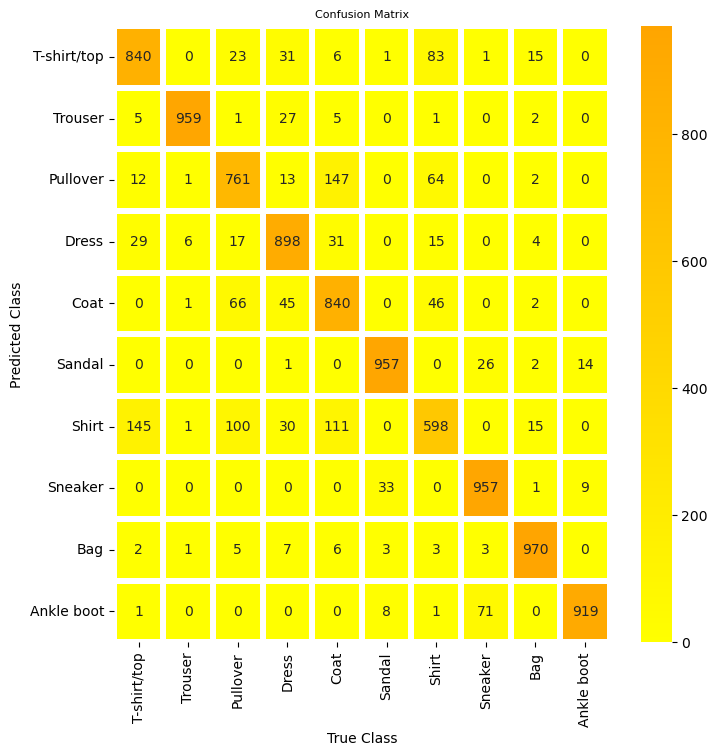

In [53]:
class_label = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
wandb.init(project="CS6910_Assignment_11", name="Question:7")
y_p = np.argmax(y_preds,1)
y_t = np.argmax(y_OH_test,1)
conf_matrix = metrics.confusion_matrix(y_t , y_p)
df_conf_matrix = pd.DataFrame(conf_matrix)
plt.figure(figsize=(8, 8))
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","orange"])
ax = sns.heatmap(df_conf_matrix, annot=True,  cmap= my_cmap, fmt='d',linewidths=3, linecolor='white')
ax.set_xticklabels(class_label,rotation=90)
ax.set_yticklabels(class_label,rotation=0)
plt.title('Confusion Matrix', fontsize=8)
plt.ylabel("Predicted Class")
plt.xlabel("True Class")  
wandb.log({"Confusion_Matrix": wandb.Image(plt)})

In [44]:
wandb.finish()

# Question 8

In [45]:
''' Parameters Selection for Different Optimization Algorithm '''
# parameters_nadam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #nadam
# parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5} #sgd
# parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0} #momentum
# parameters_nag = {"learning_rate":0.001, "gamma":0.009} #nag
# parameters_rmsprop = {"learning_rate":0.01, "gamma":0.009, "epsilon":1e-8, "weight_decay":0.5} #rmsprop
parameters_adam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #adam

'''For Selecting different Optimization Function'''
# "sgd" : gradient_descent, "momentum" : momentum_gd, "nag": nag , "rmsprop":  RMSProp, "adam": Adam "nadam": Nadam

optimizer = Optimizer("adam")
optimizer.set_initial_parameters(parameters_adam)


#  "cross_entropy" : Cross Entropy Loss Function,  "squared_loss" : Squared Error Loss Function

loss_fun_se = LossFunction("squared_loss")
train_se_losses = []
val_se_losses = []
train_se_accuracy = []
val_se_accuracy = []



loss_fun_cross = LossFunction("cross_entropy")
train_ce_losses = []
val_ce_losses = []
train_ce_accuracy = []
val_ce_accuracy = []

#Select activation-function(hidden layers) pass below respective string to select any Activation Fuction Eg:"tanh" in ActivationFunction
# "sigmoid": SigmoidFunction, "softmax": SoftmaxFunction, "tanh": TanhFunction, "relu":ReLUFunction
act_fun_hidden = ActivationFunction("tanh")

#Select activation - function for output layer
act_fun_output = ActivationFunction("softmax")

#Add layer sizes for the hidden layers
layers = [32, 64, 128]

print("SQUARED_ERROR")
model = FFNN(optimizer, layers, loss_fun_se, act_fun_hidden, act_fun_output, 64, 10, "Xavier", 0, train_se_losses, train_se_accuracy, val_se_losses, val_se_accuracy)
se_train_loss, se_val_loss, se_train_accuracy, se_val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test)

print("***********************************************************************************************************")

print("CROSS_ENTROPY")
model = FFNN(optimizer, layers, loss_fun_se, act_fun_hidden, act_fun_output, 64, 10, "Xavier", 0, train_ce_losses, train_ce_accuracy, val_ce_losses, val_ce_accuracy)
ce_train_loss, ce_val_loss, ce_train_accuracy, ce_val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test)
ln = len(val_ce_accuracy)+1

SQUARED_ERROR
Training Loss:  0.142 Val_loss: 0.117  Training Accuracy:  0.8 Val_accuracy: 0.836  <-:Epoch: 1
Training Loss:  0.107 Val_loss: 0.109  Training Accuracy:  0.851 Val_accuracy: 0.847  <-:Epoch: 2
Training Loss:  0.099 Val_loss: 0.107  Training Accuracy:  0.863 Val_accuracy: 0.851  <-:Epoch: 3
Training Loss:  0.094 Val_loss: 0.105  Training Accuracy:  0.87 Val_accuracy: 0.853  <-:Epoch: 4
Training Loss:  0.092 Val_loss: 0.104  Training Accuracy:  0.874 Val_accuracy: 0.853  <-:Epoch: 5
Training Loss:  0.089 Val_loss: 0.103  Training Accuracy:  0.878 Val_accuracy: 0.855  <-:Epoch: 6
Training Loss:  0.087 Val_loss: 0.103  Training Accuracy:  0.88 Val_accuracy: 0.855  <-:Epoch: 7
Training Loss:  0.086 Val_loss: 0.102  Training Accuracy:  0.883 Val_accuracy: 0.856  <-:Epoch: 8
Training Loss:  0.085 Val_loss: 0.102  Training Accuracy:  0.885 Val_accuracy: 0.857  <-:Epoch: 9
Training Loss:  0.084 Val_loss: 0.102  Training Accuracy:  0.887 Val_accuracy: 0.857  <-:Epoch: 10
*********

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


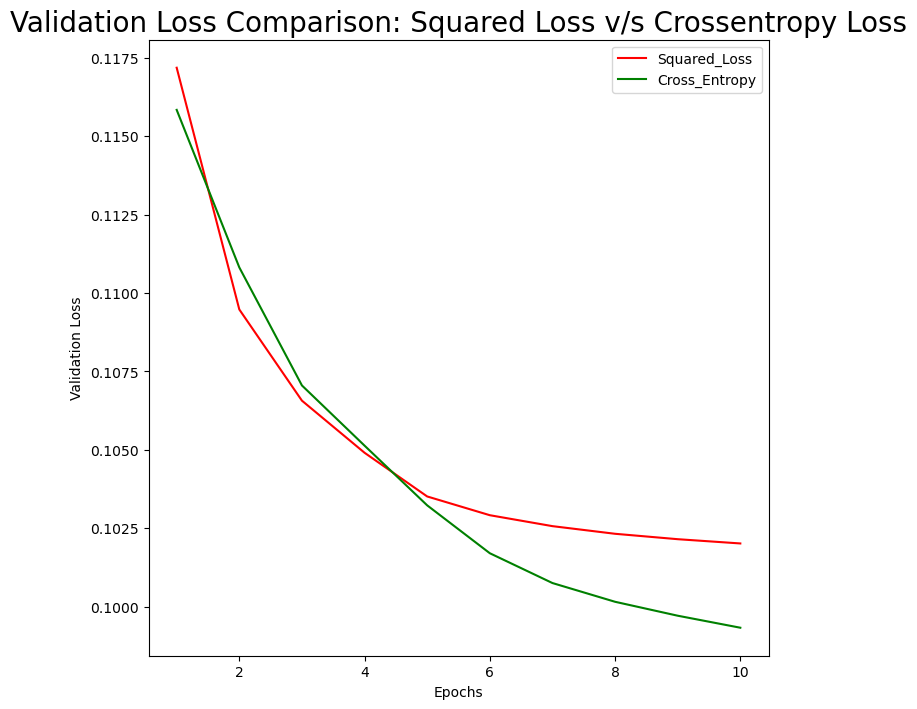

<Figure size 640x480 with 0 Axes>

In [46]:
wandb.init(project="CS6910_Assignment1", name= "Question:8")
plt.figure(figsize=(8, 8))
sizelst = list(range(1, ln))
plt.plot(sizelst, val_se_losses, 'r', label ='Squared_Loss') 
plt.plot(sizelst, val_ce_losses, 'g', label ='Cross_Entropy')
plt.title('Validation Loss Comparison: Squared Loss v/s Crossentropy Loss', fontsize=20)
plt.ylabel("Validation Loss")
plt.xlabel("Epochs") 
plt.legend()
plt.show()
wandb.log({"Validation Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})

# Question 10

In [47]:
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
enc = OneHotEncoder()
#Normalize the data
x_mnist_train = x_mnist_train/255.0
x_mnist_test = x_mnist_test/255.0

y_OH_test_mnist = enc.fit_transform(np.expand_dims(y_mnist_test, 1)).toarray()

#Splitting to get 0.1 parts of data as validation set
x_mnist_train, x_mnist_val, y_mnist_train, y_mnist_val = train_test_split(x_mnist_train, y_mnist_train, test_size=0.1, random_state=137)
y_OH_train_mnist = enc.fit_transform(np.expand_dims(y_mnist_train, 1)).toarray()
y_OH_val_mnist = enc.fit_transform(np.expand_dims(y_mnist_val, 1)).toarray()

In [48]:
# Parameters Selection for Different Optimization Algorithm
parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5} #sgd
parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0} #momentum
parameters_nag = {"learning_rate":0.001, "gamma":0.009} #nag
parameters_rmsprop = {"learning_rate":0.01, "gamma":0.009, "epsilon":1e-8, "weight_decay":0.5} #rmsprop
parameters_adam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #adam
parameters_nadam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #nadam


# "sgd" : gradient_descent, "momentum" : momentum_gd, "nag": nag , "rmsprop":  RMSProp, "adam": Adam "nadam": Nadam

optimizer = Optimizer("adam")
optimizer.set_initial_parameters(parameters_adam)


#  "cross_entropy" : Cross Entropy Loss Function,  "squared_loss" : Squared Error Loss Function
loss_fun = LossFunction("cross_entropy")

#Select activation-function(hidden layers) pass below respective string to select any Activation Fuction Eg:"tanh" in ActivationFunction
# "sigmoid": SigmoidFunction, "softmax": SoftmaxFunction, "tanh": TanhFunction, "relu":ReLUFunction
act_fun_hidden = ActivationFunction("relu")

#Select activation - function for output layer
act_fun_output = ActivationFunction("softmax")

#Add layer sizes for the hidden layers
layers = [32, 64, 128]


In [49]:
model_1 = FFNN(optimizer, layers,  loss_fun , act_fun_hidden, act_fun_output, 64, 10, initialization = "Xavier")
model_1.fit(x_mnist_train, y_OH_train_mnist, x_mnist_val, y_OH_val_mnist)

Training Loss:  0.417 Val_loss: 0.217  Training Accuracy:  0.877 Val_accuracy: 0.939  <-:Epoch: 1
Training Loss:  0.194 Val_loss: 0.163  Training Accuracy:  0.943 Val_accuracy: 0.952  <-:Epoch: 2
Training Loss:  0.15 Val_loss: 0.141  Training Accuracy:  0.954 Val_accuracy: 0.96  <-:Epoch: 3
Training Loss:  0.124 Val_loss: 0.129  Training Accuracy:  0.962 Val_accuracy: 0.965  <-:Epoch: 4
Training Loss:  0.106 Val_loss: 0.124  Training Accuracy:  0.968 Val_accuracy: 0.966  <-:Epoch: 5
Training Loss:  0.093 Val_loss: 0.118  Training Accuracy:  0.972 Val_accuracy: 0.967  <-:Epoch: 6
Training Loss:  0.082 Val_loss: 0.115  Training Accuracy:  0.976 Val_accuracy: 0.967  <-:Epoch: 7
Training Loss:  0.073 Val_loss: 0.115  Training Accuracy:  0.978 Val_accuracy: 0.969  <-:Epoch: 8
Training Loss:  0.065 Val_loss: 0.121  Training Accuracy:  0.98 Val_accuracy: 0.968  <-:Epoch: 9
Training Loss:  0.058 Val_loss: 0.125  Training Accuracy:  0.983 Val_accuracy: 0.966  <-:Epoch: 10


(0.05760434519052973,
 0.12500245117270742,
 0.982574074074074,
 0.9661666666666666)

In [50]:
optimizer = Optimizer("nadam")
optimizer.set_initial_parameters(parameters_nadam)


#  "cross_entropy" : Cross Entropy Loss Function,  "squared_loss" : Squared Error Loss Function
loss_fun = LossFunction("cross_entropy")

#Select activation-function(hidden layers) pass below respective string to select any Activation Fuction Eg:"tanh" in ActivationFunction
# "sigmoid": SigmoidFunction, "softmax": SoftmaxFunction, "tanh": TanhFunction, "relu":ReLUFunction
act_fun_hidden = ActivationFunction("tanh")

#Select activation - function for output layer
act_fun_output = ActivationFunction("softmax")
model_2 = FFNN(optimizer, layers,  loss_fun , act_fun_hidden, act_fun_output, 32, 15, initialization = "Xavier")
model_2.fit(x_mnist_train, y_OH_train_mnist, x_mnist_val, y_OH_val_mnist)

Training Loss:  0.352 Val_loss: 0.203  Training Accuracy:  0.898 Val_accuracy: 0.943  <-:Epoch: 1
Training Loss:  0.178 Val_loss: 0.154  Training Accuracy:  0.947 Val_accuracy: 0.955  <-:Epoch: 2
Training Loss:  0.134 Val_loss: 0.138  Training Accuracy:  0.96 Val_accuracy: 0.96  <-:Epoch: 3
Training Loss:  0.109 Val_loss: 0.133  Training Accuracy:  0.967 Val_accuracy: 0.964  <-:Epoch: 4
Training Loss:  0.091 Val_loss: 0.129  Training Accuracy:  0.973 Val_accuracy: 0.964  <-:Epoch: 5
Training Loss:  0.078 Val_loss: 0.127  Training Accuracy:  0.977 Val_accuracy: 0.966  <-:Epoch: 6
Training Loss:  0.068 Val_loss: 0.127  Training Accuracy:  0.98 Val_accuracy: 0.964  <-:Epoch: 7
Training Loss:  0.059 Val_loss: 0.131  Training Accuracy:  0.983 Val_accuracy: 0.964  <-:Epoch: 8
Training Loss:  0.052 Val_loss: 0.137  Training Accuracy:  0.985 Val_accuracy: 0.963  <-:Epoch: 9
Training Loss:  0.045 Val_loss: 0.142  Training Accuracy:  0.988 Val_accuracy: 0.964  <-:Epoch: 10
Training Loss:  0.039 

(0.025274249017432037,
 0.16125203268060956,
 0.9922222222222222,
 0.9626666666666667)

In [51]:
optimizer = Optimizer("nadam")
optimizer.set_initial_parameters(parameters_nadam)


#  "cross_entropy" : Cross Entropy Loss Function,  "squared_loss" : Squared Error Loss Function
loss_fun = LossFunction("cross_entropy")

#Select activation-function(hidden layers) pass below respective string to select any Activation Fuction Eg:"tanh" in ActivationFunction
# "sigmoid": SigmoidFunction, "softmax": SoftmaxFunction, "tanh": TanhFunction, "relu":ReLUFunction
act_fun_hidden = ActivationFunction("relu")

#Select activation - function for output layer
act_fun_output = ActivationFunction("softmax")
model_3 = FFNN(optimizer, layers,  loss_fun , act_fun_hidden, act_fun_output, 64, 16, initialization = "Xavier")
model_3.fit(x_mnist_train, y_OH_train_mnist, x_mnist_val, y_OH_val_mnist)

Training Loss:  0.419 Val_loss: 0.216  Training Accuracy:  0.875 Val_accuracy: 0.938  <-:Epoch: 1
Training Loss:  0.196 Val_loss: 0.157  Training Accuracy:  0.942 Val_accuracy: 0.954  <-:Epoch: 2
Training Loss:  0.15 Val_loss: 0.141  Training Accuracy:  0.955 Val_accuracy: 0.96  <-:Epoch: 3
Training Loss:  0.124 Val_loss: 0.131  Training Accuracy:  0.962 Val_accuracy: 0.963  <-:Epoch: 4
Training Loss:  0.106 Val_loss: 0.126  Training Accuracy:  0.968 Val_accuracy: 0.964  <-:Epoch: 5
Training Loss:  0.093 Val_loss: 0.121  Training Accuracy:  0.972 Val_accuracy: 0.965  <-:Epoch: 6
Training Loss:  0.082 Val_loss: 0.121  Training Accuracy:  0.976 Val_accuracy: 0.967  <-:Epoch: 7
Training Loss:  0.073 Val_loss: 0.12  Training Accuracy:  0.978 Val_accuracy: 0.967  <-:Epoch: 8
Training Loss:  0.065 Val_loss: 0.123  Training Accuracy:  0.981 Val_accuracy: 0.966  <-:Epoch: 9
Training Loss:  0.058 Val_loss: 0.122  Training Accuracy:  0.983 Val_accuracy: 0.968  <-:Epoch: 10
Training Loss:  0.052 

(0.030778866269608688,
 0.13318754991504142,
 0.9914444444444445,
 0.9703333333333334)

In [52]:
y_pred1 = model_1.predict(x_mnist_test)
y_pred2 = model_2.predict(x_mnist_test)
y_pred3 = model_3.predict(x_mnist_test)


print("Model-1 Test Accuracy:-", accuracy_score(np.argmax(y_OH_test_mnist,1), np.argmax(y_pred1,1)))
print("Model-2 Test Accuracy:-", accuracy_score(np.argmax(y_OH_test_mnist,1), np.argmax(y_pred2,1)))
print("Model-3 Test Accuracy:-", accuracy_score(np.argmax(y_OH_test_mnist,1), np.argmax(y_pred3,1)))

Model-1 Test Accuracy:- 0.9648
Model-2 Test Accuracy:- 0.9654
Model-3 Test Accuracy:- 0.9688
